# auto_annot_Smillie2019_with_Haber2017_dblabel

In [1]:
import besca as bc
import pandas as pd
import pkg_resources

/pstore/home/hatjek/.conda/envs/besca_test/lib/python3.6/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


### Specify folders where .h5ad files are found and their names. 

The datasets that are already annotated and should be used for training. If you only use one dataset please use list of one.

In [2]:
# the path to the datasets
train_dataset_paths = [pkg_resources.resource_filename('besca', 'datasets/data')]
#the names of the h5ad files
train_datasets =['haber_processed.h5ad']

The dataset of interest that should be annotated.

In [3]:
test_dataset = 'Smillie2019_processed.h5ad'
test_dataset_path =  pkg_resources.resource_filename('besca', 'datasets/data')

Give your analysis a name.

In [4]:
analysis_name = 'auto_annot_Smillie2019_with_Haber2017_dblabel' 

### Now specify parameters

Specify column name of celltype annotation you want to train on.

In [5]:
celltype_train ='dblabel' 
celltype_test = 'dblabel'

Choose a method:

- linear: Support Vector Machine with Linear Kernel
- sgd: Support Vector Machine with Linear Kernel using Stochastic Gradient Descent
- rbf: Support Vector Machine with radial basis function kernel. Very time intensive, use only on small datasets.
- logistic_regression: Standard logistic classifier iwth multinomial loss.
- logistic_regression_ovr: Logistic Regression with one versus rest classification.
- logistic_regression_elastic: Logistic Regression with elastic loss, cross validates among multiple l1 ratios.

In [6]:
method = 'logistic_regression'

Specify merge method if using multiple training datasets. Needs to be either scanorama or naive.

In [7]:
merge = 'scanorama'

Decide if you want to use the raw format or highly variable genes. Raw increases computational time and does not necessarily improve predictions.

In [8]:
use_raw = False

You can choose to only consider a subset of genes from a signature set.

In [9]:
genes_to_use = 'all'

### Read in all training and the testing set.

In [77]:
adata_trains, adata_pred, adata_orig = bc.tl.auto_annot.read_data(train_paths = train_dataset_paths,train_datasets= train_datasets, test_path=  test_dataset_path, test_dataset= test_dataset, use_raw = use_raw)

Transforming to str index.


Reading files


Transforming to str index.


In [78]:
# Select epithelial subset from Smillie2019 dataset
epithelial_subset = bc.subset_adata(adata_orig, adata_orig.obs.celltype_highlevel == 'Epi', raw=False)
adata_orig = epithelial_subset

In [79]:
# Convert mouse symbols (HGNC) to human symbols (MGI)
mousehuman_file = pkg_resources.resource_filename('besca', 'datasets/homologs/MGItoHGNC.csv')
mousehuman=pd.read_csv(mousehuman_file,sep='\t',header='infer', encoding="unicode_escape")
mousehuman.index=mousehuman['HGNC']
conversion=pd.Series(data=mousehuman['MGI'], index=mousehuman.index)

In [80]:
# Convert mouse symbols (HGNC) to human symbols (MGI)
adata_orig.var.rename(columns={'SYMBOL':'HGNC'}, inplace=True)
adata_orig.var['SYMBOL'] = adata_orig.var['HGNC'].map(lambda x: conversion.get(x, default='') if type(conversion.get(x, default='')) == str else str(conversion.get(x, default=None).values[0]))
adata_orig.var.index = adata_orig.var.SYMBOL
adata_orig.var_names_make_unique(join='abcdef')
adata_pred = adata_orig.copy()

This function merges training datasets, removes unwanted genes, and if scanorama is used corrects for datasets.

In [82]:
adata_train, adata_pred = bc.tl.auto_annot.merge_data(adata_trains, adata_pred, genes_to_use = genes_to_use, merge = merge)

merging with scanorama
using scanorama rn
Found 265 genes among all datasets
[[0.         0.73312055]
 [0.         0.        ]]
Processing datasets (0, 1)
integrating training set
calculating intersection


### Train the classifier.

The returned scaler is fitted on the training dataset (to zero mean and scaled to unit variance).

In [83]:
classifier, scaler = bc.tl.auto_annot.fit(adata_train, method, celltype_train)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:   19.2s finished


### Prediction

Use fitted model to predict celltypes in adata_pred. Prediction will be added in a new column called 'auto_annot'. Paths are needed as adata_pred will revert to its original state (all genes, no additional corrections).
The threshold should be set to 0 or left out for SVM. For logisitic regression the threshold can be set.

In [84]:
adata_predicted = bc.tl.auto_annot.adata_predict(classifier = classifier, scaler = scaler, adata_pred = adata_pred, adata_orig = adata_orig, threshold = 0.7)

Write out metrics to a report file, create confusion matrices and comparative umap plots

In [85]:
adata_pred.obs

,CELL,Cluster,Health,Location,Subject,celltype_highlevel,nGene,nUMI,original_name,percent_mito,n_counts,n_genes,batch,leiden,dblabel,celltype,cluster_celltype,Type
0,N7.EpiA.AAGCAAGAGTCAAC-Epi,Cycling TA,Non-inflamed,Epi,N7,Epi,1507,7428,N7.EpiA.AAGCAAGAGTCAAC,0.057351,7428.0,1507,N7,8,proliferating transit amplifying cell,epithelial cell,8: epithelial cell,Epithelial
1,N7.EpiA.ACGAGGGAGCTGAT-Epi,Enterocyte Progenitors,Non-inflamed,Epi,N7,Epi,828,2877,N7.EpiA.ACGAGGGAGCTGAT,0.009037,2877.0,828,N7,0,enterocyte progenitor,epithelial cell,0: epithelial cell,Epithelial
2,N7.EpiA.ACGTTTACTGGTAC-Epi,Immature Enterocytes 2,Non-inflamed,Epi,N7,Epi,2318,15332,N7.EpiA.ACGTTTACTGGTAC,0.133707,15332.0,2318,N7,7,immature enterocyte,enterocyte,7: enterocyte,Epithelial
3,N7.EpiA.AGAGAATGGTCATG-Epi,Enterocyte Progenitors,Non-inflamed,Epi,N7,Epi,884,3498,N7.EpiA.AGAGAATGGTCATG,0.002001,3498.0,884,N7,7,enterocyte progenitor,enterocyte,7: enterocyte,Epithelial
4,N7.EpiA.AGAGCGGAGTATGC-Epi,TA 1,Non-inflamed,Epi,N7,Epi,858,3261,N7.EpiA.AGAGCGGAGTATGC,0.003067,3261.0,858,N7,0,transit amplifying cell,epithelial cell,0: epithelial cell,Epithelial
5,N7.EpiA.AGATTAACGCCATA-Epi,Cycling TA,Non-inflamed,Epi,N7,Epi,2743,20160,N7.EpiA.AGATTAACGCCATA,0.097123,20160.0,2743,N7,8,proliferating transit amplifying cell,epithelial cell,8: epithelial cell,Epithelial
6,N7.EpiA.AGGATGCTTACAGC-Epi,TA 2,Non-inflamed,Epi,N7,Epi,812,2764,N7.EpiA.AGGATGCTTACAGC,0.003618,2764.0,812,N7,0,transit amplifying cell,epithelial cell,0: epithelial cell,Epithelial
7,N7.EpiA.AGGTACACAGACTC-Epi,Cycling TA,Non-inflamed,Epi,N7,Epi,3109,23926,N7.EpiA.AGGTACACAGACTC,0.062192,23926.0,3109,N7,8,proliferating transit amplifying cell,epithelial cell,8: epithelial cell,Epithelial
8,N7.EpiA.AGTCTACTTCTCTA-Epi,TA 2,Non-inflamed,Epi,N7,Epi,1945,12338,N7.EpiA.AGTCTACTTCTCTA,0.083806,12338.0,1945,N7,0,transit amplifying cell,epithelial cell,0: epithelial cell,Epithelial
9,N7.EpiA.ATAGTCCTTAACCG-Epi,TA 2,Non-inflamed,Epi,N7,Epi,2172,13869,N7.EpiA.ATAGTCCTTAACCG,0.128055,13869.0,2172,N7,0,transit amplifying cell,epithelial cell,0: epithelial cell,Epithelial


/pstore/home/hatjek/.conda/envs/besca_test/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/pstore/home/hatjek/.conda/envs/besca_test/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

... storing 'auto_annot' as categorical


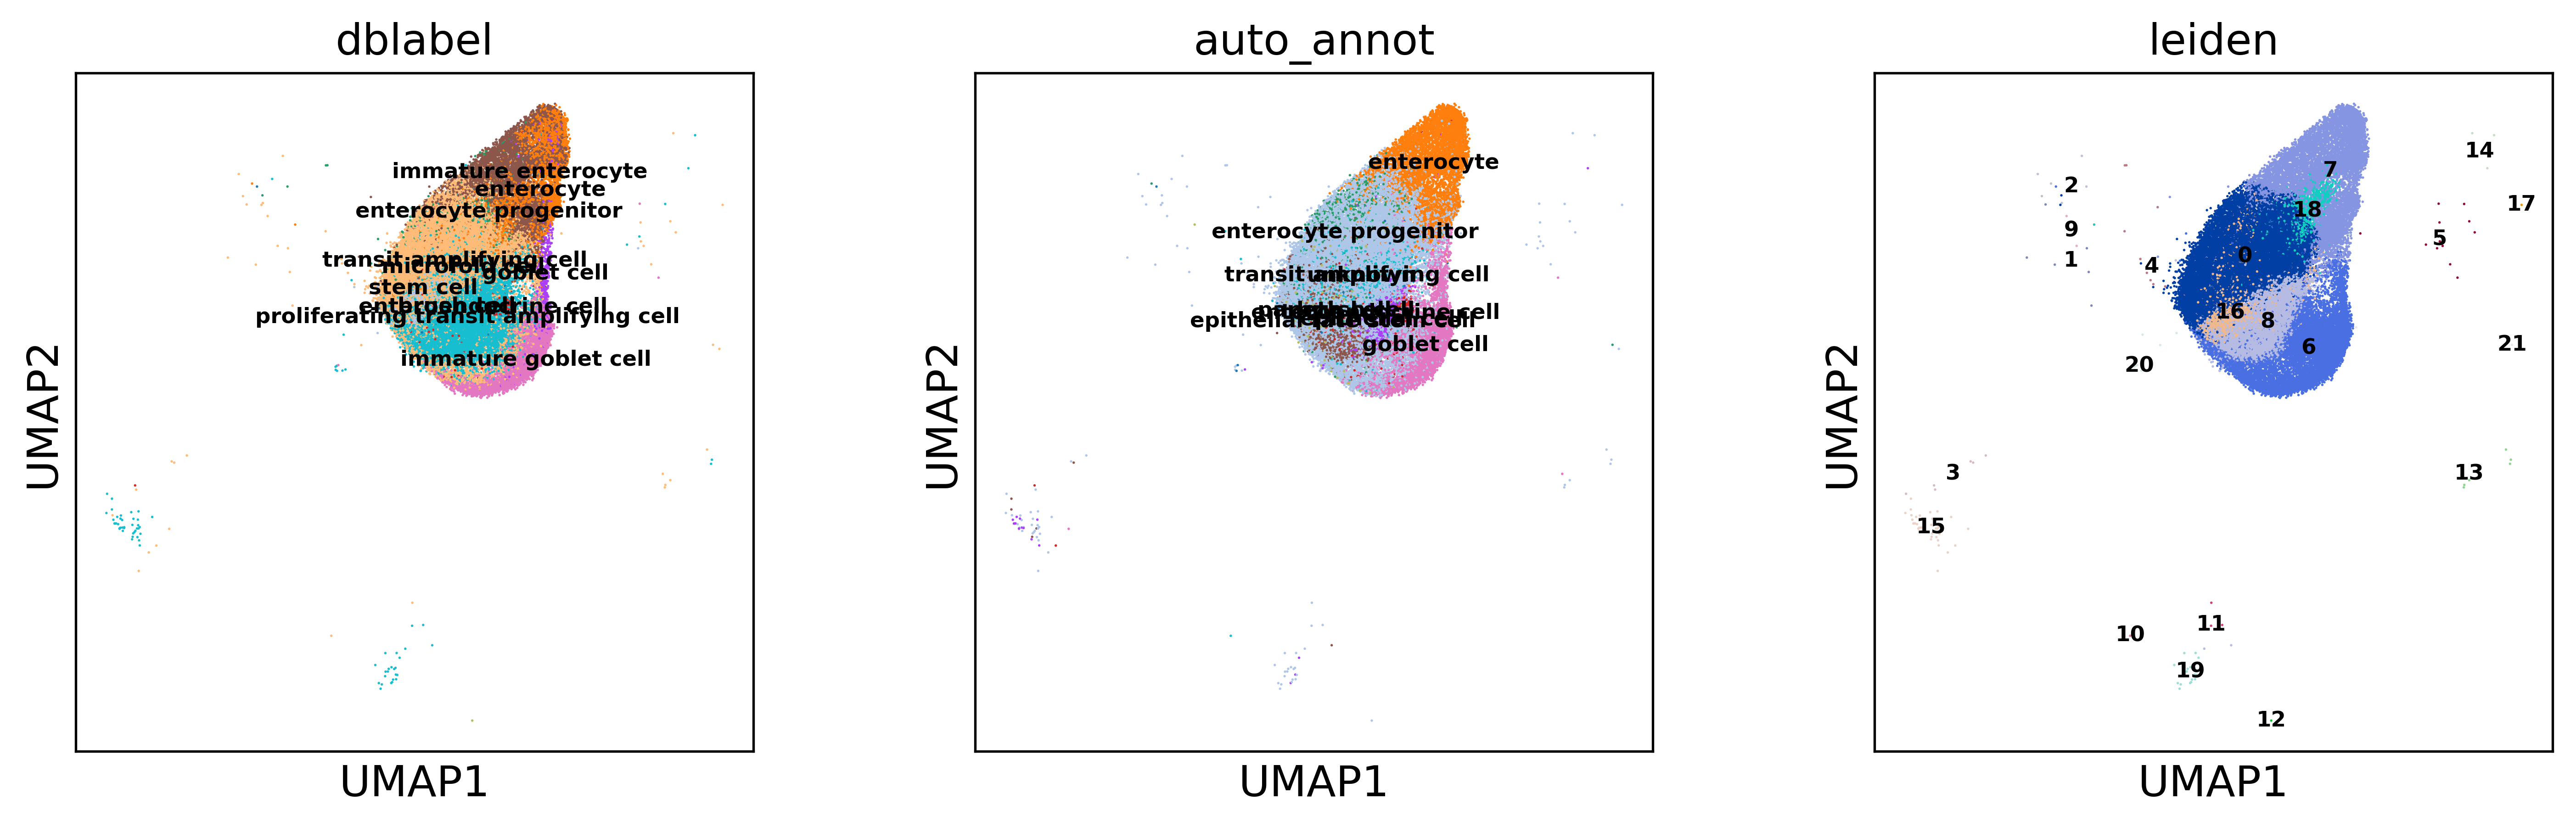

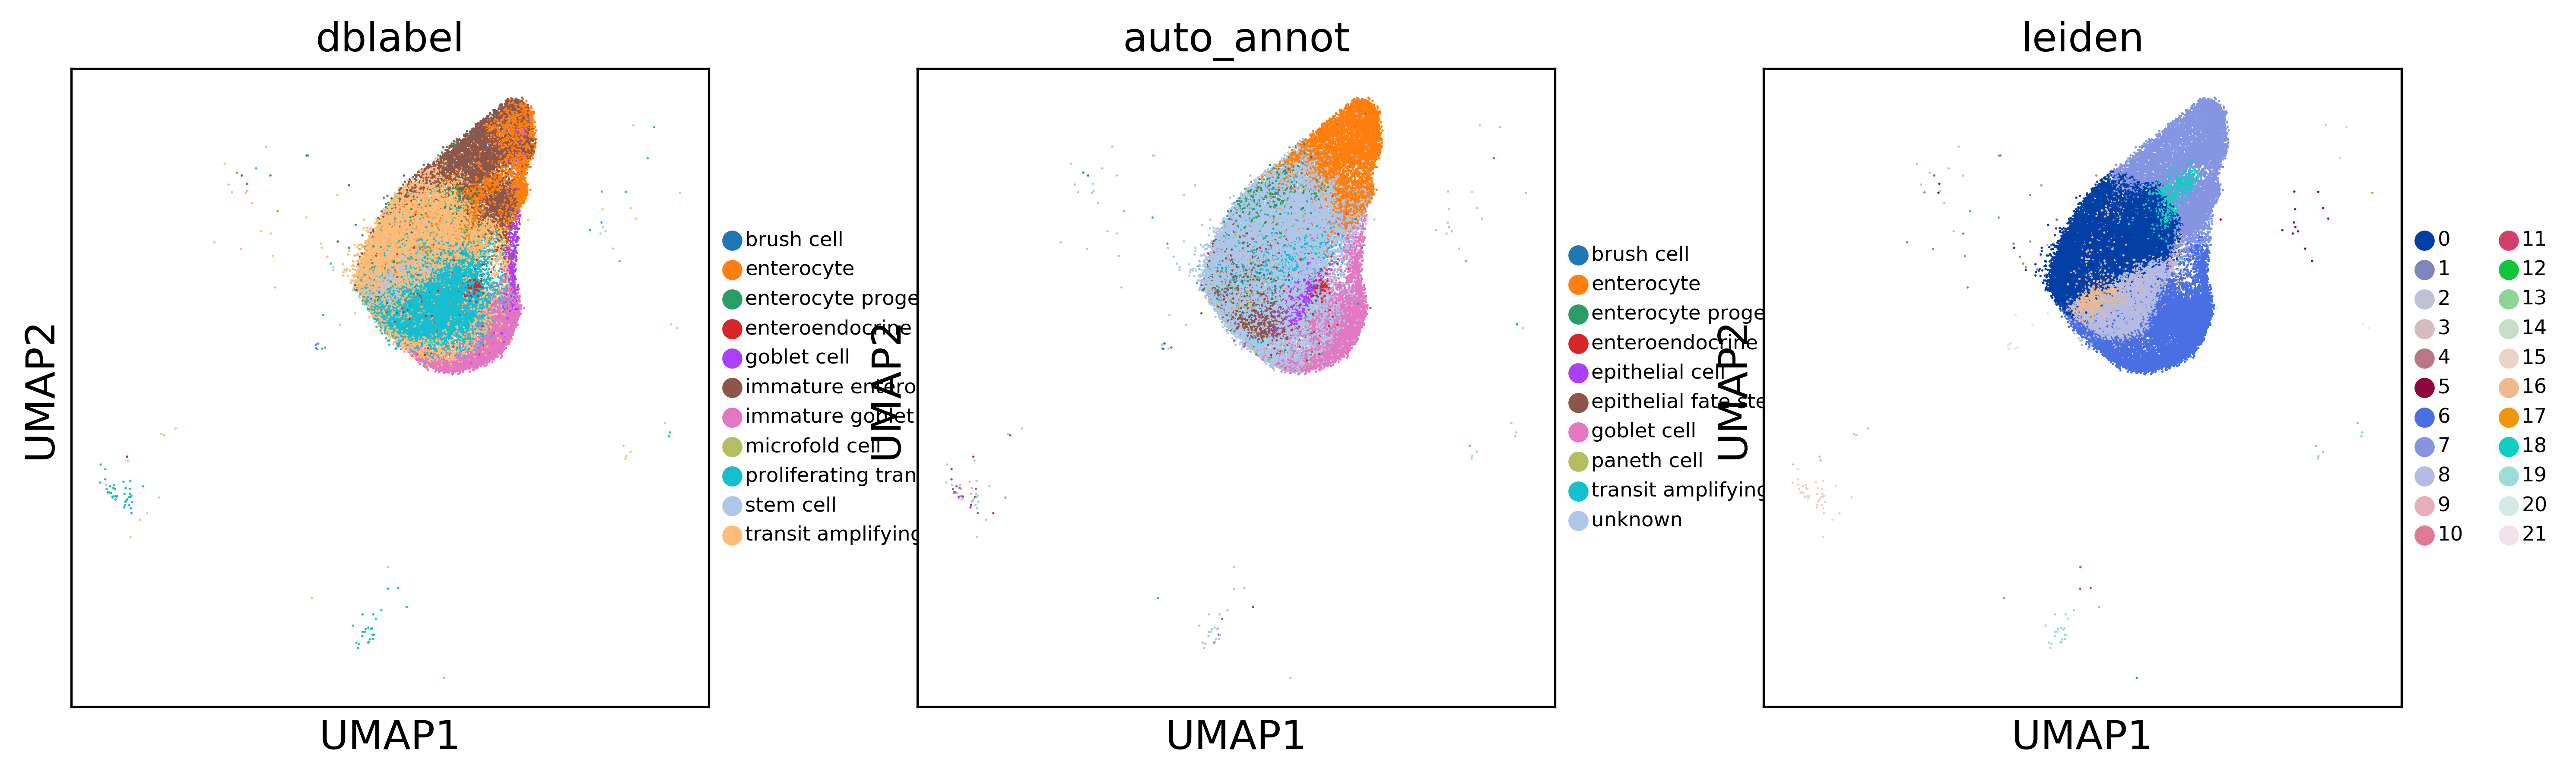

Confusion matrix, without normalization
Normalized confusion matrix


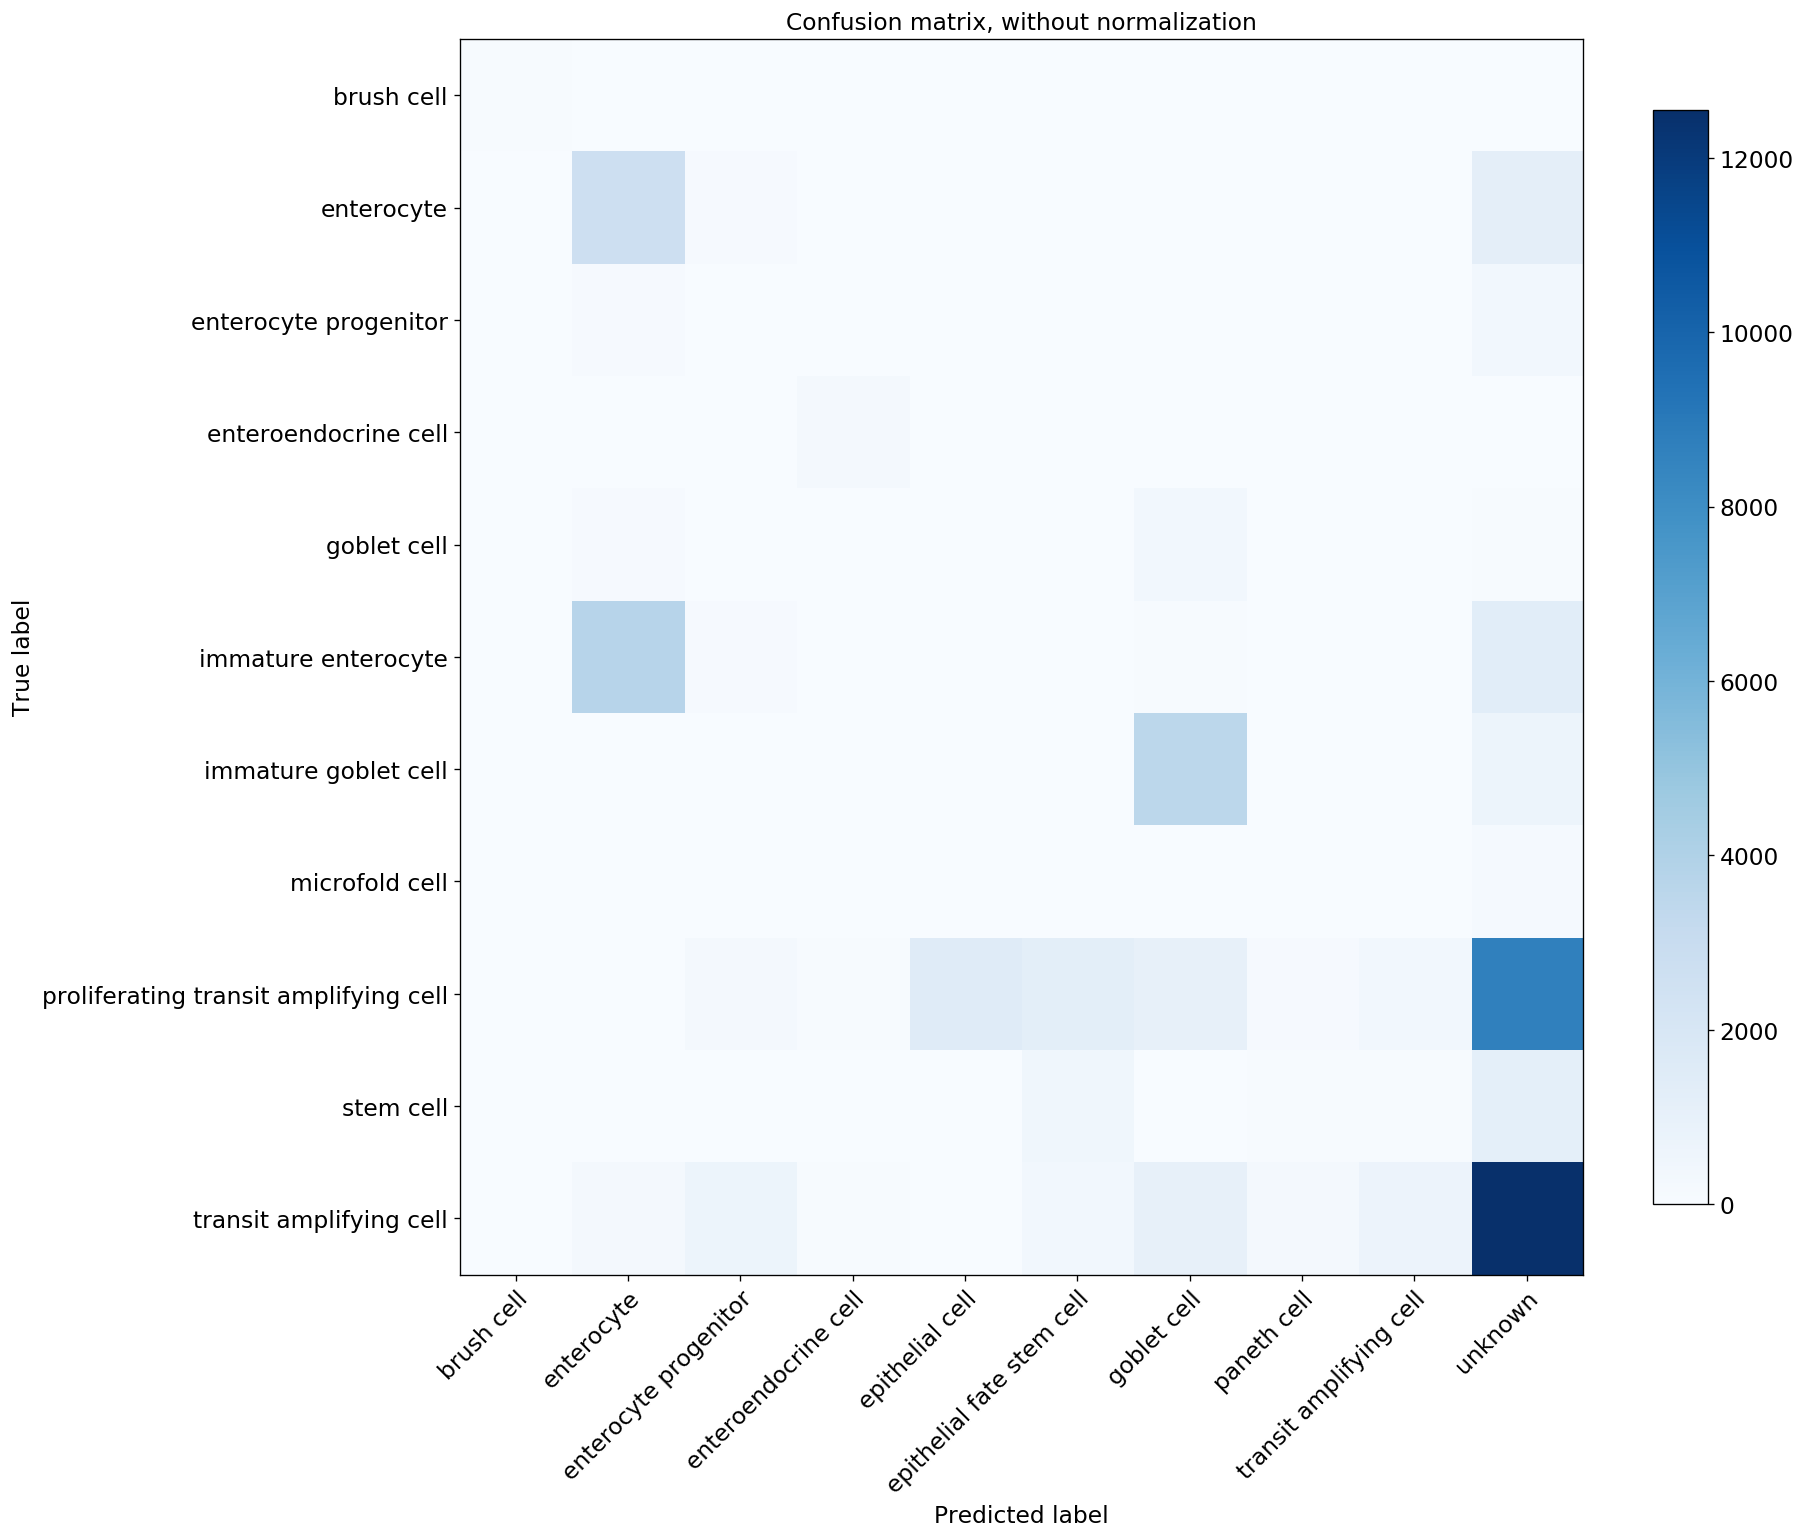

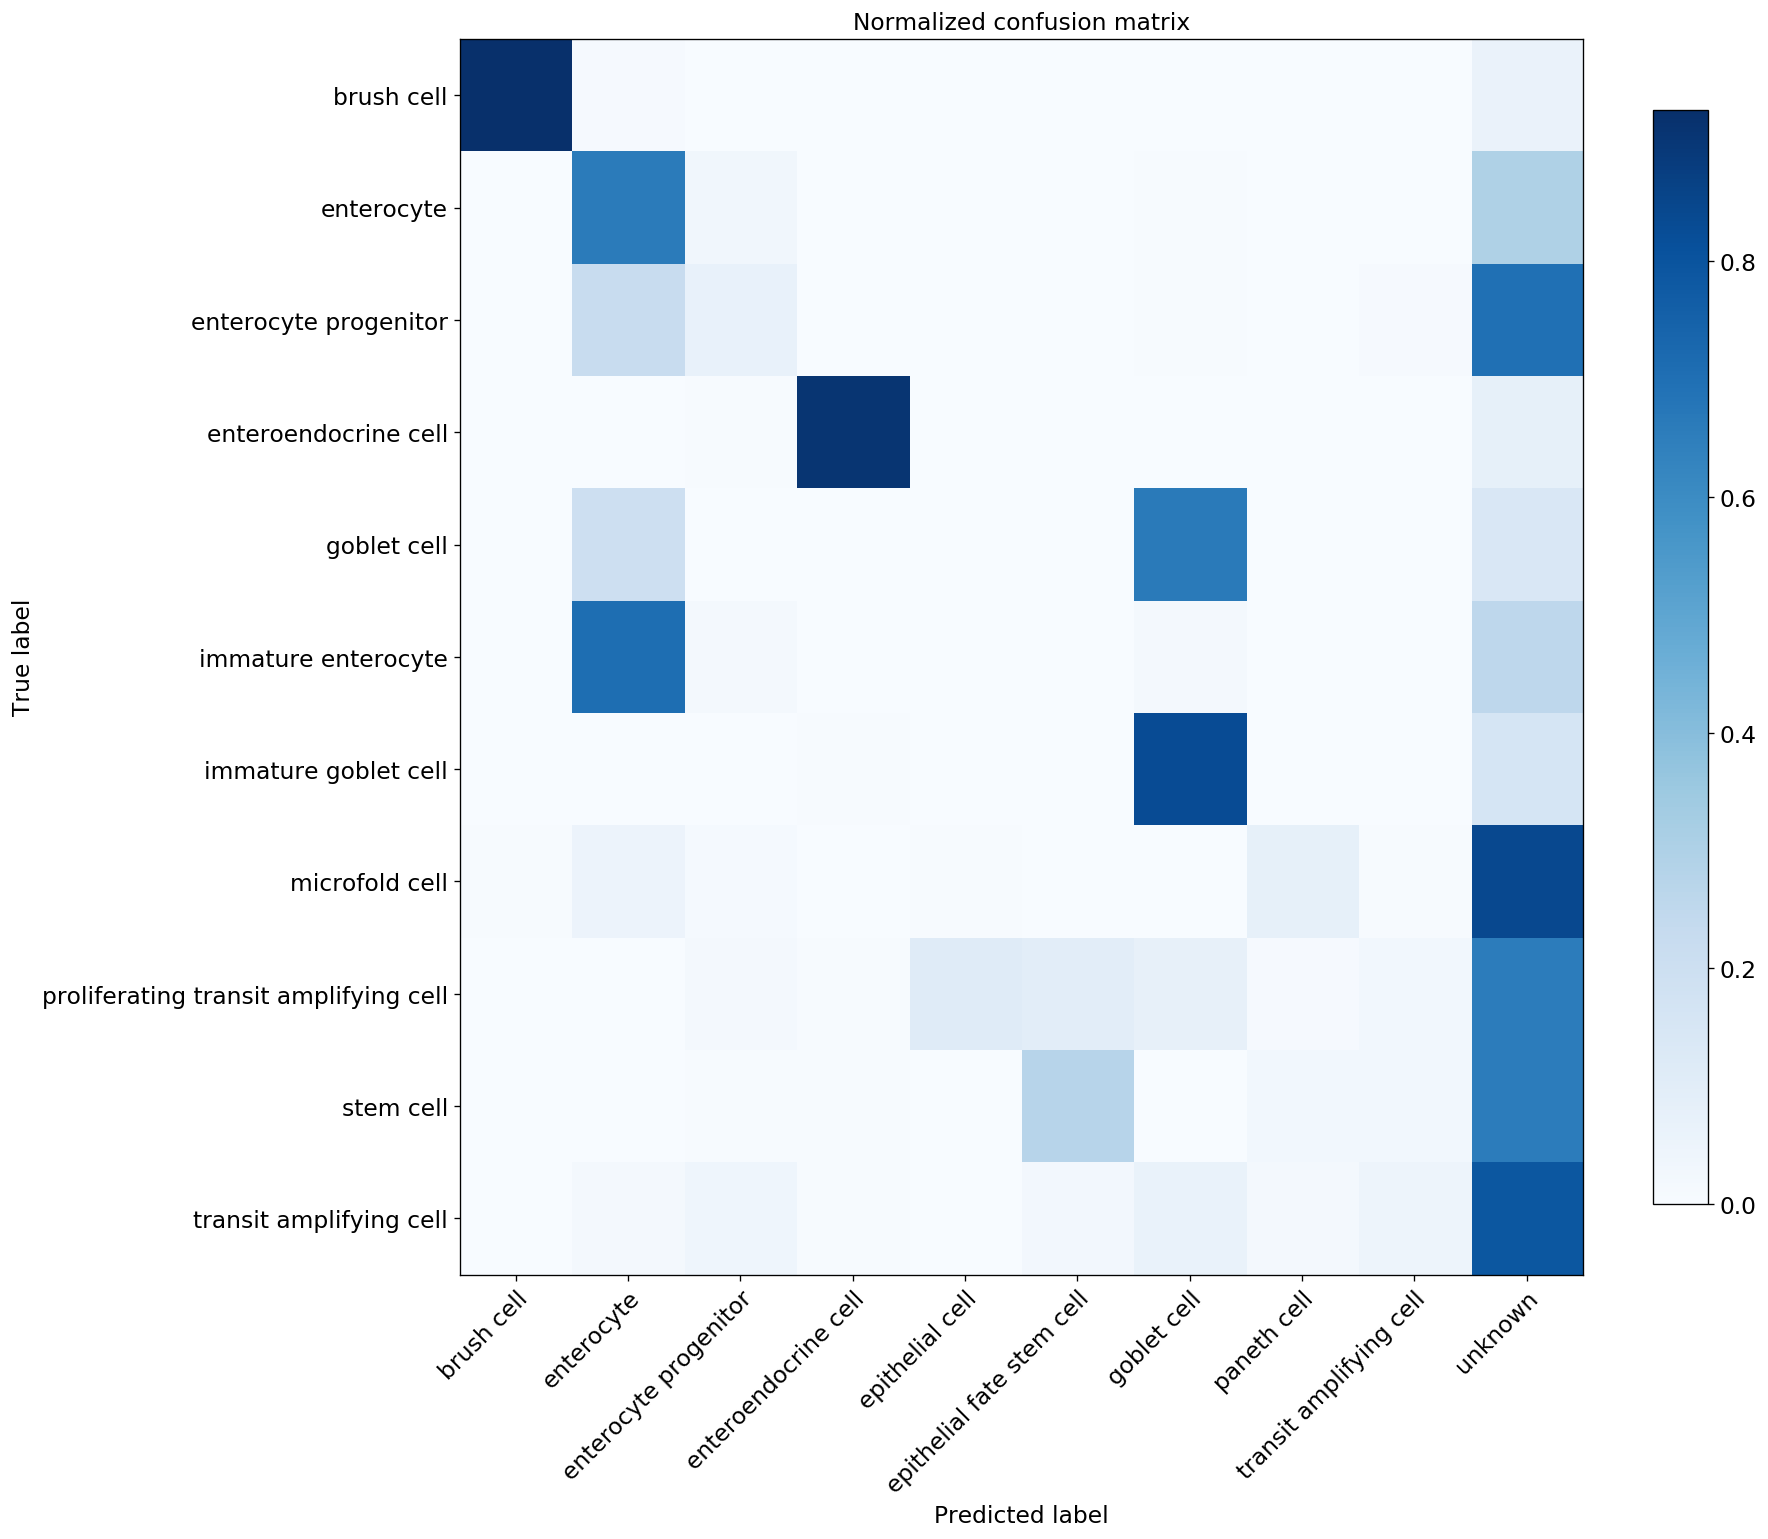

In [86]:
%matplotlib inline

bc.tl.auto_annot.report(adata_pred=adata_predicted, celltype=celltype_test, method=method, analysis_name=analysis_name,
                        train_datasets=train_datasets, test_dataset=test_dataset, merge=merge, use_raw=False,
                        genes_to_use=genes_to_use, remove_nonshared=True, clustering='leiden', asymmetric_matrix=True)

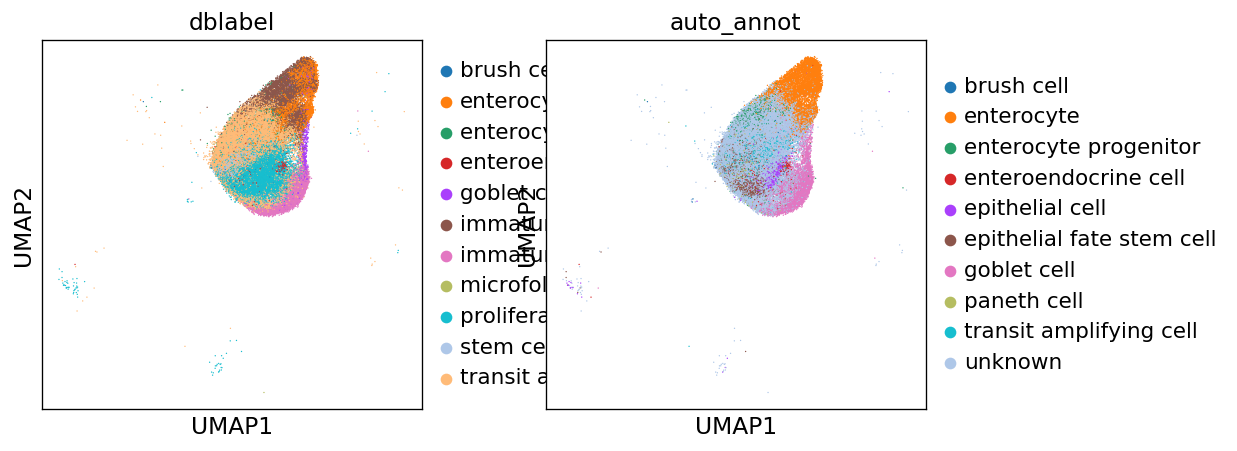

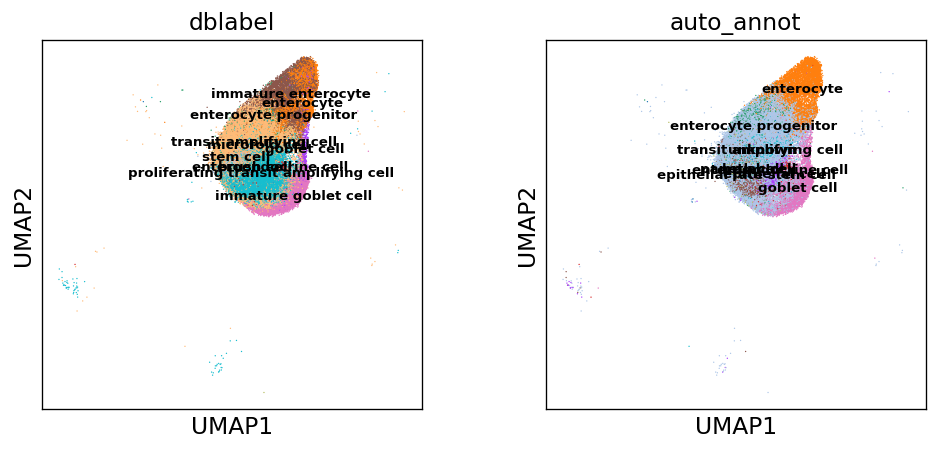

In [87]:
import scanpy as sc
sc.pl.umap(adata_predicted, color=[celltype_test, 'auto_annot'])
sc.pl.umap(adata_predicted, color=[celltype_test, 'auto_annot'], legend_loc='on data', legend_fontsize=8)

In [88]:
adata_train

View of AnnData object with n_obs × n_vars = 12219 × 265 
    obs: 'CELL', 'CONDITION', 'sample_type', 'donor', 'region', 'sample', 'percent_mito', 'n_counts', 'n_genes', 'leiden', 'celltype0', 'celltype1', 'celltype2', 'celltype3', 'dblabel'
    var: 'ENSEMBL-0', 'SYMBOL', 'n_cells-0', 'total_counts-0', 'frac_reads-0', 'ENSEMBL-1', 'HGNC-1', 'n_cells-1', 'total_counts-1', 'frac_reads-1'